# Amplitude damping channel

In [51]:
from sympy import I, sqrt, symbols, exp, cos, sin, Symbol, Add, Matrix
from sympy.physics.quantum import TensorProduct as ox

theta, psi = symbols(r"\theta, \phi", real=True)
p = Symbol(r"p", positive=True, real=True)

dpsi = Matrix([0, cos(theta), exp(I * psi) * sin(theta), 0])

M_0 = Matrix([[1, 0], [0, sqrt(1-p)]])
M_1 = Matrix([[0, sqrt(p)], [0, 0]])

rho_ab = Add(*[ox(m_u, m_v) * (dpsi * dpsi.H) * ox(m_u.H, m_v.H) for m_u in [M_0, M_1] for m_v in [M_0, M_1]])

rho_ab

Matrix([
[p*sin(\theta)**2 + p*cos(\theta)**2,                                                                      0,                                                                       0, 0],
[                                  0,                      sqrt(1 - p)*cos(\theta)**2*conjugate(sqrt(1 - p)), sqrt(1 - p)*exp(-I*\phi)*sin(\theta)*cos(\theta)*conjugate(sqrt(1 - p)), 0],
[                                  0, sqrt(1 - p)*exp(I*\phi)*sin(\theta)*cos(\theta)*conjugate(sqrt(1 - p)),                       sqrt(1 - p)*sin(\theta)**2*conjugate(sqrt(1 - p)), 0],
[                                  0,                                                                      0,                                                                       0, 0]])

In [28]:
f_psi = (ox(M_0, M_0) + ox(M_1, M_1)) * (dpsi * dpsi.H)

f_psi

Matrix([
[0,                                               0,                                                0, 0],
[0,                      sqrt(1 - p)*cos(\theta)**2, sqrt(1 - p)*exp(-I*\phi)*sin(\theta)*cos(\theta), 0],
[0, sqrt(1 - p)*exp(I*\phi)*sin(\theta)*cos(\theta),                       sqrt(1 - p)*sin(\theta)**2, 0],
[0,                                               0,                                                0, 0]])

In [5]:
def baseTrace(m: Matrix, base: int) -> Matrix:
    if not m.is_square:
        raise Exception("Matrix should be square")
    
    s = int(m.shape[0] / (2 / 2**base))
    d = int(m.shape[0] / 2) - base
    return Matrix([[m[i, j] + m[i + d, j + d] for i in range(0, s, base + 1)] for j in range(0, s, base + 1)])

baseTrace(rho_ab, 0).subs(sqrt(1- p).conjugate(), sqrt(1 - p))

Matrix([
[p*sin(\theta)**2 + p*cos(\theta)**2 + (1 - p)*sin(\theta)**2,                      0],
[                                                           0, (1 - p)*cos(\theta)**2]])

# Experiment

In [106]:
from qiskit import QuantumCircuit, Aer
from qiskit_experiments.library import StateTomography
from qiskit.quantum_info.operators import Operator, SparsePauliOp
from qiskit_ibm_runtime import QiskitRuntimeService, Estimator, Session, Sampler
from qiskit.visualization import array_to_latex, plot_state_city
from qiskit_aer import AerSimulator
from math import pi, cos, sin, asin, sqrt

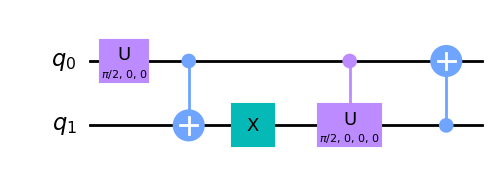

In [214]:
p = 0.5
theta = 2 * asin(sqrt(p))

qc = QuantumCircuit(2)
qc.u(pi / 2, 0, 0, 0)
qc.cx(0, 1)
qc.x(1)
qc.cu(theta, 0, 0, 0, 0, 1)
qc.cx(1, 0)
qc.draw("mpl")

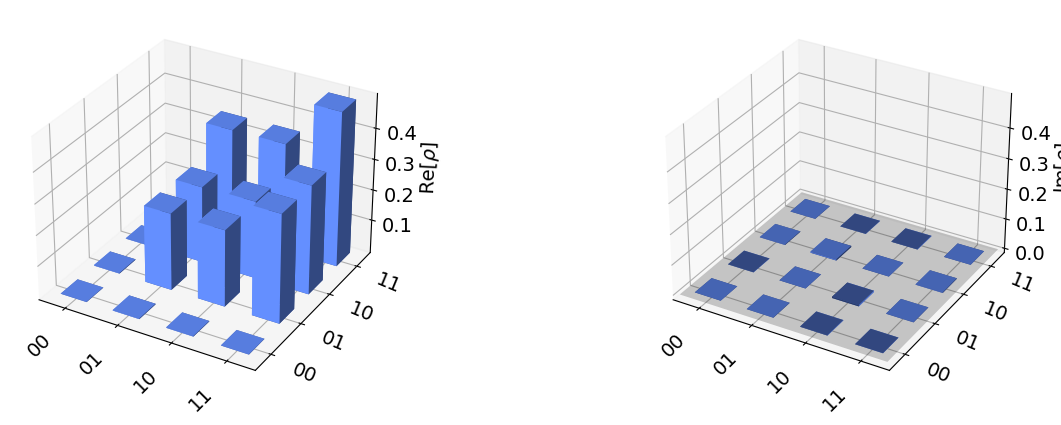

In [215]:
backend = Aer.get_backend("aer_simulator")
st = StateTomography(qc)
stdata = st.run(backend, shots=10000).block_for_results()
state_result = stdata.analysis_results("state")
# array_to_latex(state_result.value)
plot_state_city(state_result.value)

In [198]:
# Print results
for result in stdata.analysis_results():
    print(result)

AnalysisResult
- name: state
- value: DensityMatrix([[ 0.00065863+0.j        , -0.0023193 +0.00137889j,
                -0.00153439+0.00072323j, -0.00054869-0.00071215j],
               [-0.0023193 -0.00137889j,  0.49907371+0.j        ,
                 0.49821086-0.00392097j,  0.00074052-0.00071725j],
               [-0.00153439-0.00072323j,  0.49821086+0.00392097j,
                 0.49900116+0.j        ,  0.00083867-0.00213867j],
               [-0.00054869+0.00071215j,  0.00074052+0.00071725j,
                 0.00083867+0.00213867j,  0.00126649+0.j        ]],
              dims=(2, 2))
- extra: <7 items>
- device_components: ['Q0', 'Q1']
- verified: False
AnalysisResult
- name: state_fidelity
- value: 0.997248295778068
- device_components: ['Q0', 'Q1']
- verified: False
AnalysisResult
- name: positive
- value: True
- device_components: ['Q0', 'Q1']
- verified: False


In [44]:
service = QiskitRuntimeService()
with Session(service=service, backend="ibmq_belem") as session:
     sampler = Sampler()
     job = sampler.run(qc)
     print(f">>> Job ID: {job.job_id()}")
     result = job.result()
     session.close()

print(result)

>>> Job ID: ci3o4n0kbvp2ovok55tg
SamplerResult(quasi_dists=[{0: 0.8415743024440588, 1: -0.001579426707446109, 2: 0.008036559581150434, 3: 0.15196856468223666}], metadata=[{'shots': 4000, 'readout_mitigation_overhead': 1.4531764730056917, 'readout_mitigation_time': 0.09331333900627214}])


In [54]:
array_to_latex(SparsePauliOp("ZZ").to_matrix())

<IPython.core.display.Latex object>